# TSP 算法性能分析

本 Notebook 用于运行 TSP 算法并分析性能指标。

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 设置中文显示（可选）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 120

## 1. 选择并运行算法

In [2]:
# ========== 配置：选择要运行的 tour 文件 ==========
TOUR_FILE = 'tour750.csv'  # 可选: tour50.csv, tour250.csv, tour500.csv, tour750.csv, tour1000.csv

# 运行结果保存目录
RESULTS_DIR = 'perf_results'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
# 运行算法
import test_performance

print(f"正在运行: {TOUR_FILE}")
print("预计运行时间: 5 分钟...")
print("="*50)

solver = test_performance.r0927480()
result = solver.optimize(TOUR_FILE)

print("="*50)
print(f"运行完成！最佳路径长度: {result['best_fitness']:.2f}")
print(f"总代数: {result['generations']}")

正在运行: tour750.csv
预计运行时间: 5 分钟...
运行完成！最佳路径长度: 103337.32
总代数: 2596


In [4]:
# 保存结果到带时间戳的文件
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
tour_name = TOUR_FILE.replace('.csv', '')
result_file = os.path.join(RESULTS_DIR, f'{tour_name}_{timestamp}.json')

# 准备保存数据（numpy 数组转为 list）
save_data = {
    'tour_file': TOUR_FILE,
    'timestamp': timestamp,
    'best_fitness': result['best_fitness'],
    'best_tour': result['best_tour'].tolist(),
    'generations': result['generations'],
    'metrics': result['metrics']
}

with open(result_file, 'w') as f:
    json.dump(save_data, f, indent=2)

print(f"结果已保存到: {result_file}")

结果已保存到: perf_results\tour750_20251228_010607.json


## 2. 查看性能指标摘要

In [5]:
m = result['metrics']

print("=" * 50)
print("              性 能 指 标 摘 要")
print("=" * 50)

# EAX-lite
eax_rate = m['eax_success'] / m['eax_attempts'] * 100 if m['eax_attempts'] > 0 else 0
print(f"\n【EAX-lite 交叉】")
print(f"  尝试次数:    {m['eax_attempts']:,}")
print(f"  成功次数:    {m['eax_success']:,}")
print(f"  成功率:      {eax_rate:.1f}%")
print(f"  SCX 回退:    {m['scx_fallback']:,}")

# RTR
rtr_total = m['rtr_accepts'] + m['rtr_rejects']
rtr_rate = m['rtr_accepts'] / rtr_total * 100 if rtr_total > 0 else 0
print(f"\n【RTR 替换选择】")
print(f"  接受:        {m['rtr_accepts']:,}")
print(f"  拒绝:        {m['rtr_rejects']:,}")
print(f"  接受率:      {rtr_rate:.1f}%")

# Scout
print(f"\n【Scout 并行搜索】")
print(f"  发送病人:    {m['scout_sent']:,}")
print(f"  接收解:      {m['scout_received']:,}")
print(f"  打破最优:    {m['scout_improved']:,}")

# GLS & Restart
print(f"\n【逃脱策略】")
print(f"  GLS 激活:    {m['gls_activations']:,}")
print(f"  种群重启:    {m['restart_count']:,}")

# Diversity
if m['history_diversity']:
    print(f"\n【种群多样性】")
    print(f"  初始:        {m['history_diversity'][0]:.1f}")
    print(f"  最终:        {m['history_diversity'][-1]:.1f}")

print("\n" + "=" * 50)

              性 能 指 标 摘 要

【EAX-lite 交叉】
  尝试次数:    207,555
  成功次数:    123,995
  成功率:      59.7%
  SCX 回退:    83,560

【RTR 替换选择】
  接受:        45,983
  拒绝:        473,217
  接受率:      8.9%

【Scout 并行搜索】
  发送病人:    43
  接收解:      577
  打破最优:    17

【逃脱策略】
  GLS 激活:    17
  种群重启:    6

【种群多样性】
  初始:        606.6
  最终:        332.8



## 3. 绘制分析图（紧凑布局）

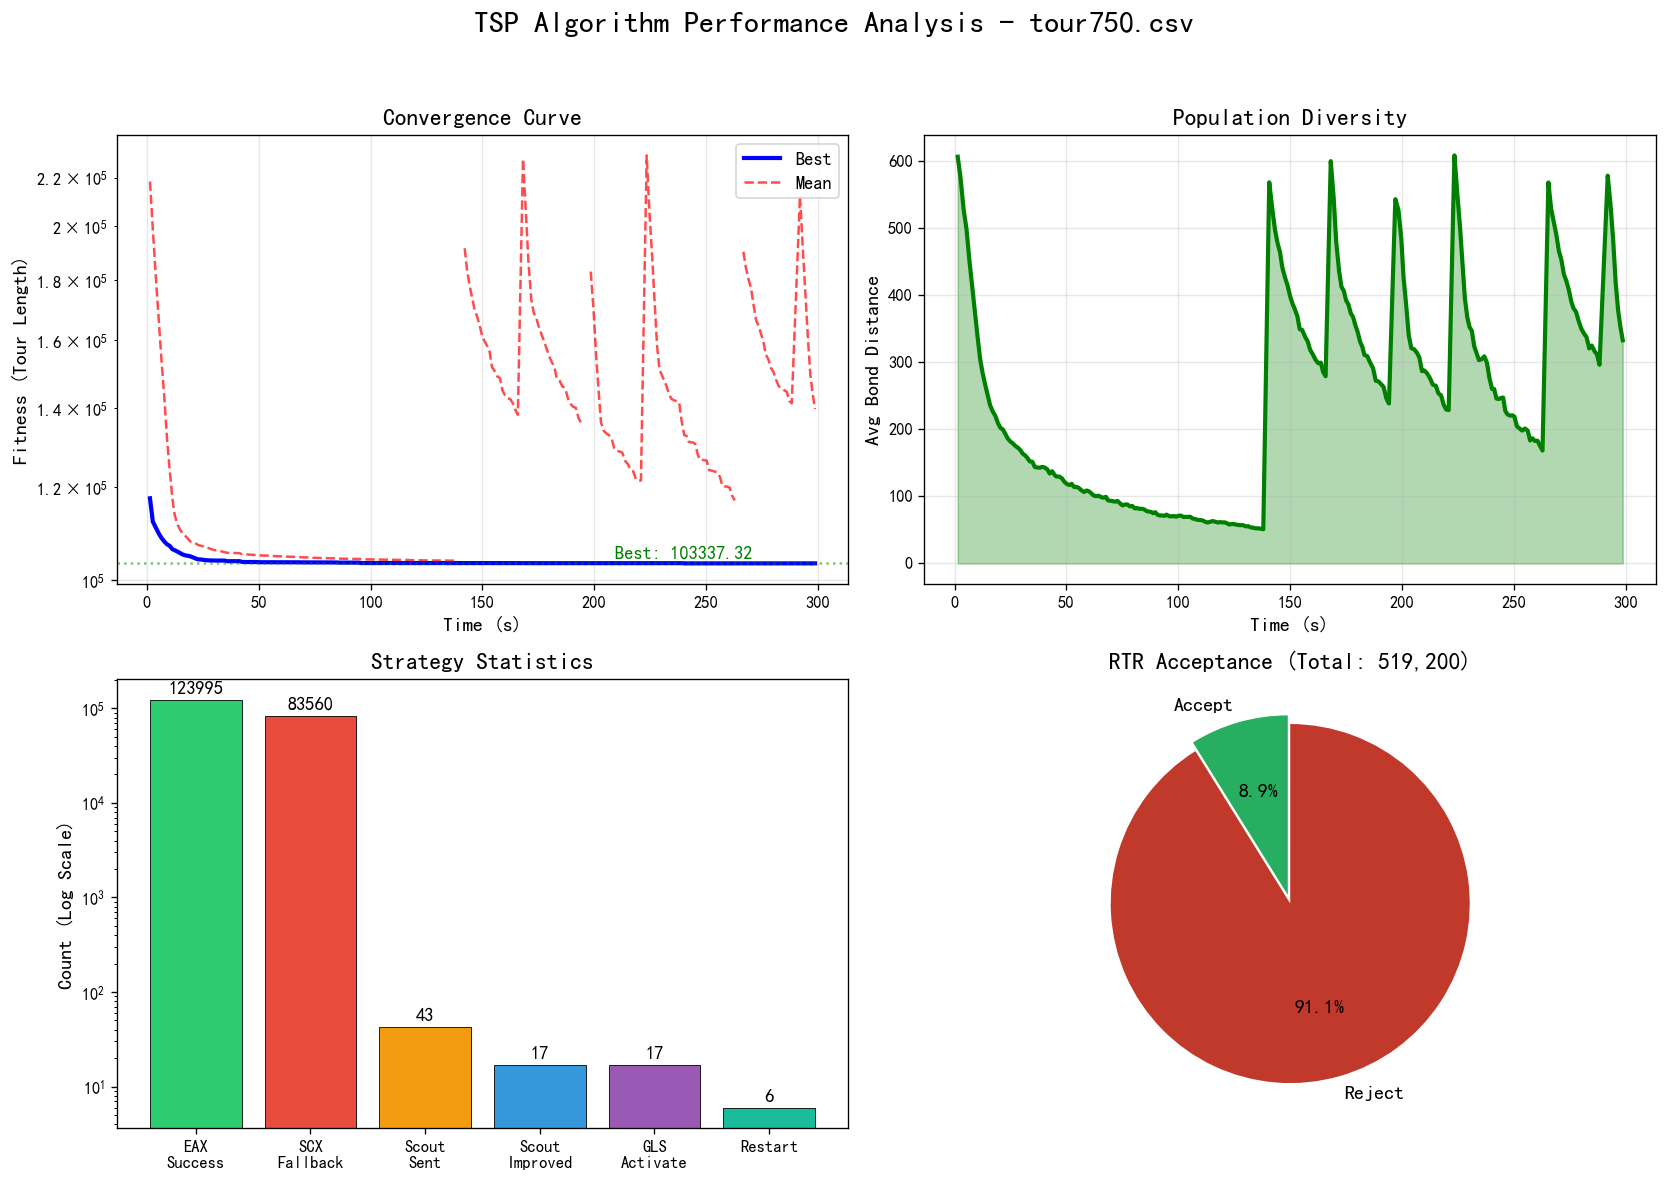

图片已保存到: perf_results/tour750_20251228_010607_analysis.png


In [6]:
m = result['metrics']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'TSP Algorithm Performance Analysis - {TOUR_FILE}', fontsize=18, fontweight='bold')

# ========== 图1: 收敛曲线 ==========
ax1 = axes[0, 0]
if m['history_time']:
    ax1.plot(m['history_time'], m['history_best'], 'b-', linewidth=2.5, label='Best')
    ax1.plot(m['history_time'], m['history_mean'], 'r--', linewidth=1.5, alpha=0.7, label='Mean')
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('Fitness (Tour Length)', fontsize=12)
    ax1.set_title('Convergence Curve', fontsize=14)
    ax1.legend(loc='upper right', fontsize=11)
    ax1.tick_params(axis='both', labelsize=10)
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    # 标注最终最佳值
    ax1.axhline(y=result['best_fitness'], color='g', linestyle=':', alpha=0.5)
    ax1.text(m['history_time'][-1]*0.7, result['best_fitness']*1.01, 
             f'Best: {result["best_fitness"]:.2f}', fontsize=11, color='g')

# ========== 图2: 种群多样性 ==========
ax2 = axes[0, 1]
if m['history_diversity']:
    ax2.plot(m['history_time'], m['history_diversity'], 'g-', linewidth=2.5)
    ax2.fill_between(m['history_time'], m['history_diversity'], alpha=0.3, color='g')
    ax2.set_xlabel('Time (s)', fontsize=12)
    ax2.set_ylabel('Avg Bond Distance', fontsize=12)
    ax2.set_title('Population Diversity', fontsize=14)
    ax2.tick_params(axis='both', labelsize=10)
    ax2.grid(True, alpha=0.3)

# ========== 图3: 策略统计条形图 ==========
ax3 = axes[1, 0]
categories = ['EAX\nSuccess', 'SCX\nFallback', 'Scout\nSent', 'Scout\nImproved', 'GLS\nActivate', 'Restart']
values = [
    m['eax_success'],
    m['scx_fallback'],
    m['scout_sent'], 
    m['scout_improved'],
    m['gls_activations'],
    m['restart_count']
]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db', '#9b59b6', '#1abc9c']
bars = ax3.bar(categories, values, color=colors, edgecolor='black', linewidth=0.5)
ax3.set_ylabel('Count (Log Scale)', fontsize=12)
ax3.set_title('Strategy Statistics', fontsize=14)
ax3.set_yscale('log')
ax3.tick_params(axis='both', labelsize=10)
# 添加数值标签
for bar, val in zip(bars, values):
    if val > 0:
        # 在 log 轴上，y 坐标偏移需要更小心，这里向上乘一个因子
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
                 f'{val}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# ========== 图4: RTR 饼图 ==========
ax4 = axes[1, 1]
rtr_data = [m['rtr_accepts'], m['rtr_rejects']]
if sum(rtr_data) > 0:
    wedges, texts, autotexts = ax4.pie(
        rtr_data, 
        labels=['Accept', 'Reject'],
        autopct='%1.1f%%',
        colors=['#27ae60', '#c0392b'],
        explode=(0.05, 0),
        startangle=90,
        textprops={'fontsize': 12}
    )
    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')
    ax4.set_title(f'RTR Acceptance (Total: {sum(rtr_data):,})', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(RESULTS_DIR, f'{tour_name}_{timestamp}_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"图片已保存到: {RESULTS_DIR}/{tour_name}_{timestamp}_analysis.png")

## 4. （可选）加载历史结果进行分析

In [ ]:
# 列出所有保存的结果
result_files = sorted([f for f in os.listdir(RESULTS_DIR) if f.endswith('.json')])
print("可用的历史结果文件:")
for i, f in enumerate(result_files):
    print(f"  [{i}] {f}")

In [ ]:
# 加载指定的历史结果（修改 index 选择不同文件）
index = 0  # 选择要加载的文件索引

if result_files:
    with open(os.path.join(RESULTS_DIR, result_files[index]), 'r') as f:
        loaded_result = json.load(f)
    
    print(f"已加载: {result_files[index]}")
    print(f"Tour: {loaded_result['tour_file']}")
    print(f"Best Fitness: {loaded_result['best_fitness']:.2f}")
    print(f"Generations: {loaded_result['generations']}")
    
    # 可以重新使用上面的绘图代码，将 result 替换为 loaded_result
    # m = loaded_result['metrics']

## 5. 最佳路径城市序列

In [ ]:
print(f"最佳路径长度: {result['best_fitness']:.2f}")
print(f"城市序列 (共 {len(result['best_tour'])} 个城市):")
print(result['best_tour'].tolist())